In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import os
from torch import optim, cuda
from torch.optim import lr_scheduler
from torchvision import models
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
import matplotlib.image as read
import pickle
from PIL import Image
from torch.utils.data import DataLoader, sampler,Dataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy


In [2]:
use_gpu = torch.cuda.is_available()
print(use_gpu)
    

True


In [3]:
vgg = models.vgg16(pretrained=True)
print(vgg)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [5]:
# freezing model
for parameters in vgg.features.parameters():
    parameters.requires_grad=False

# modifying layers adding classification layers    
vgg.classifier[6]=nn.Sequential(
                                            nn.Linear(4096,10,True),  
                                            )
 
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
if use_gpu:
    vgg = vgg.to('cuda')

In [7]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [8]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=5),
        #transforms.ColorJitter(),
        #transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
print(image_transforms['train'])

Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [9]:
#reading file
path = os.path.join('..','input','sample')
csvFile = pd.read_csv('../input/sample/sample_labels.csv')
print(len(csvFile))


5606


In [10]:
#Storing images
imageArray=[]
labelArray=[]

# add image paths to array
def addImages(i,name):
    imagePaths='../input/sample/sample/sample/images/'
    imagePaths+=csvFile['Image Index'][i]
    imageArray.append(imagePaths)
    labelArray.append(name)
    #arr.append(imagePaths)



# Adding covid images path to array  
path = "../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/"
for filename in os.listdir(path):
    filePath = '../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/'
    filePath += filename
    imageArray.append(filePath)
    labelArray.append('COVID-19')
    #Covid.append(filePath)
    

#Reading csv and seperating the labels
for i in range(len(csvFile)):
    label = csvFile['Finding Labels'][i]
    if 'Cardiomegaly' in label:
        addImages(i,'Cardiomegaly')
    if 'Atelectasis' in label:
        addImages(i,'Atelectasis')
    if 'Effusion' in label:
        addImages(i,'Effusion')
    if 'Infiltration' in label:
        addImages(i,'Infiltration')
    if 'Mass' in label:
        addImages(i,'Mass')
    if 'Nodule' in label:
        addImages(i,'Nodule')
    if 'Pneumothorax' in label:
        addImages(i,'Pneumothorax')
    if 'Pneumonia' in label:
        addImages(i,'Pneumonia')
    if 'No Finding' in label:
        addImages(i,'Normal')



In [11]:
#encoding labels to integer values [0,1,2...]
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labelArray)

#decode=le.inverse_transform(targets) to be used later
print(len(targets))

# Making dictonory to convert to dataframe
dataFrame={'Images':imageArray,
           'Labels':targets}



df = pd.DataFrame (dataFrame, columns = ['Images','Labels'])
dataArray=np.array(df)
x_train,x_test,y_train,y_test = train_test_split(df['Images'],df['Labels'],random_state=42,test_size=0.2,shuffle=True)
x_test,x_valid,y_test,y_valid = train_test_split(x_test,y_test,random_state=42,test_size=0.2,shuffle=True)

7377


In [12]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

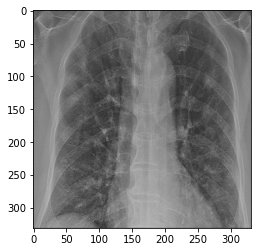

In [13]:
#load image in rgb
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    
imageCheck=pil_loader(dataArray[250][0])
# To show normal image
imgplot = plt.imshow(imageCheck)
plt.show()
imageCheck=image_transforms['train'](imageCheck)
#To show the tensor
#ax = plt.subplot(1, 1,1)
#imshow_tensor(imageCheck,ax)




In [14]:

class CustomDataLoader(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y=y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image = pil_loader(self.x[index])
        label = self.y[index]
        return image_transforms['train'](image),torch.tensor(label)
    
dataloader = DataLoader(CustomDataLoader(np.array(x_train),np.array(y_train)),batch_size=5, shuffle=True)

'''
for testing purposes
trainiter=iter(dataloader)
features, labels = next(trainiter)
print(labels.shape)
'''

    


'\nfor testing purposes\ntrainiter=iter(dataloader)\nfeatures, labels = next(trainiter)\nprint(labels.shape)\n'

In [15]:
# setting loss function and optimizer
# not a good result
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(vgg.parameters())
#----------------changing functions-----------------------#
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(vgg.parameters(),lr=0.01)
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# training
# Main loop
#vgg=torch.load('trainedmodel3.pth')
epochs=120
size = len(x_train)
print(size)
best_acc=0.000
vgg.train(True)
best =copy.deepcopy(vgg)

for i in range(epochs):
  # Initialize validation loss for epoch
    train_loss = 0.000
    train_acc =  0.000
   
    
    
    for data, targets in dataloader:
        # Generate predictions
        if use_gpu:
            data, targets = data.cuda(), targets.cuda()
        optimizer.zero_grad()
        out = vgg(data)
        # Calculate loss
        loss = criterion(out, targets)

        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()

         # Track train loss by multiplying average loss by number of examples in batch
        #train_loss += loss.item() * data.size(0)

       
        _, pred = torch.max(out, dim=1)
       
        
        train_loss += loss.item()
        train_acc += torch.sum(pred == targets.data)
        
    
    train_loss /= len(x_train)
    train_acc  /= len(x_train)
    if(train_acc>best_acc):
        best_acc = float(train_acc)
        best_model= copy.deepcopy(vgg.state_dict())
        best =copy.deepcopy(vgg)
    
    print(f" Epoch: {i+1}","Avg loss (train): {:.4f}".format(train_loss),"Avg acc (train): {:.4f}".format(train_acc))
    



    
    
    

5901
 Epoch: 1 Avg loss (train): 0.2915 Avg acc (train): 0.5477
 Epoch: 2 Avg loss (train): 0.2743 Avg acc (train): 0.5641
 Epoch: 3 Avg loss (train): 0.2657 Avg acc (train): 0.5662
 Epoch: 4 Avg loss (train): 0.2572 Avg acc (train): 0.5726
 Epoch: 5 Avg loss (train): 0.2489 Avg acc (train): 0.5831
 Epoch: 6 Avg loss (train): 0.2432 Avg acc (train): 0.5948
 Epoch: 7 Avg loss (train): 0.2311 Avg acc (train): 0.6006
 Epoch: 8 Avg loss (train): 0.2253 Avg acc (train): 0.6085
 Epoch: 9 Avg loss (train): 0.2136 Avg acc (train): 0.6311
 Epoch: 10 Avg loss (train): 0.2025 Avg acc (train): 0.6477
 Epoch: 11 Avg loss (train): 0.1946 Avg acc (train): 0.6528
 Epoch: 12 Avg loss (train): 0.1842 Avg acc (train): 0.6706
 Epoch: 13 Avg loss (train): 0.1750 Avg acc (train): 0.6870
 Epoch: 14 Avg loss (train): 0.1659 Avg acc (train): 0.7077
 Epoch: 15 Avg loss (train): 0.1542 Avg acc (train): 0.7180
 Epoch: 16 Avg loss (train): 0.1491 Avg acc (train): 0.7350
 Epoch: 17 Avg loss (train): 0.1395 Avg acc 

In [17]:
#for saving purposes
torch.save(best, 'trainedmodel.pth')
torch.save(vgg, 'latestmodel.pth')
#torch.save(best, 'trainedmodel3.pth')

In [18]:
#print(best_acc)
#torch.save(best_model, 'full_trained_model.pth')

In [20]:
train_loss=0.0
train_acc=0.0
vgg=torch.load('trainedmodel.pth')
vgg.eval()

testloader= DataLoader(CustomDataLoader(np.array(x_test),np.array(y_test)),batch_size=5, shuffle=True)
vgg.train(False)
for data, targets in testloader:
        # Generate predictions
    if use_gpu:
        data, targets = data.cuda(), targets.cuda()
    out = vgg(data)
        # Calculate loss
    loss = criterion(out, targets)
    _, pred = torch.max(out, dim=1)
    train_loss += loss.item()
    train_acc += torch.sum(pred == targets.data)
        
train_loss /= len(x_test)
train_acc  /= len(x_test)
   
print("test loss (train): {:.4f}".format(train_loss))
print("test acc (train): {:.4f}".format(train_acc))
   

test loss (train): 0.6805
test acc (train): 0.5271


In [21]:
train_loss=0.0
train_acc=0.0
vgg=torch.load('trainedmodel.pth')
vgg.eval()
validloader= DataLoader(CustomDataLoader(np.array(x_valid),np.array(y_valid)),batch_size=5, shuffle=True)
vgg.train(False)
for data, targets in validloader:
            # Generate predictions
    if use_gpu:
        data, targets = data.cuda(), targets.cuda()
    out = vgg(data)
            # Calculate loss
    loss = criterion(out, targets)
    _, pred = torch.max(out, dim=1)
    train_loss += loss.item()
    train_acc += torch.sum(pred == targets.data)

train_loss /= len(x_valid)
train_acc  /= len(x_valid)
    
print("validation loss (train): {:.4f}".format(train_loss))
print("validation acc (train): {:.4f}".format(train_acc))


validation loss (train): 0.6348
validation acc (train): 0.5000
